Populating the interactive namespace from numpy and matplotlib
Cu_orbs =  ['d3z2r2', 'dx2y2', 'dxy', 'dxz', 'dyz']
O1_orbs =  ['px']
O2_orbs =  ['py']
symmetries =  ['1A1', '1A2', '3A2', '1B1', '3B1', '1E', '3E']
E_1S =  12.66
E_1G =  8.26
E_1D =  7.21
E_3P =  7.55
E_3F =  5.3
Mc= 20
VS.dim =  327645
No. of states with count_upup, count_updn, count_dnup, count_dndn: 81810 82225 81800 81810
start create_tpd_nn_matrix
start create_tpp_nn_matrix
start create_edep_diag_matrix
len(d_list) 45 Nd= 45
start computing A_dd(w) for sym 1A1
orbitals in sym  1A1 =  [('dyz', 'dyz'), ('dxz', 'dxz'), ('dxy', 'dxy'), ('d3z2r2', 'd3z2r2'), ('dx2y2', 'dx2y2')]
dd_state_indices 83808 , state: S=  0  Sz=  1 orb=  dx2y2 dx2y2
start computing A_dd(w) for sym 1A2
orbitals in sym  1A2 =  [('dx2y2', 'dxy')]
dd_state_indices 83809 , state: S=  0  Sz=  1 orb=  dxy dx2y2
start computing A_dd(w) for sym 3A2
orbitals in sym  3A2 =  [('dxz', 'dyz'), ('dx2y2', 'dxy')]
dd_state_indices 83815 , state: S=  1  Sz=  0 orb=

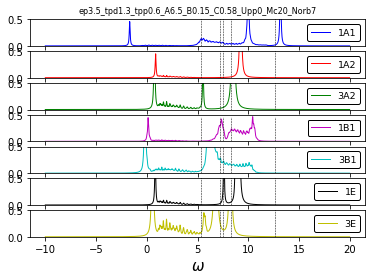

In [1]:
%pylab inline

import math
import numpy as np
from scipy.sparse.linalg import inv
#from numpy.linalg import inv
import scipy.sparse as sps
import scipy.sparse.linalg
import sys
import matplotlib.pyplot as plt
sys.path.append('../../src/')
from pylab import *

import parameters as pam
import lattice as lat
import variational_space as vs
import hamiltonian as ham
import basis_change as basis
import lanczos

M_PI = math.pi
Mc  = pam.Mc
print 'Mc=',Mc

w_vals = pam.w_vals
Norb = pam.Norb
eta = pam.eta
ed  = pam.ed
ep  = pam.ep

if Norb==3 or Norb==7:
    tpd = pam.tpd
    tpp = pam.tpp
elif Norb==9:
    pds = pam.pds
    pdp = pam.pdp
    pps = pam.pps
    ppp = pam.ppp
    
Upp = pam.Upp
if Norb==3:
    Udd = pam.Udd
elif Norb==7 or Norb==9:
    A = pam.A
    B = pam.B
    C = pam.C

if Norb==3:
    fname = 'ep'+str(ep)+'_tpd'+str(tpd)+'_tpp'+str(tpp)+ \
                '_Udd'+str(Udd)+'_Upp'+str(Upp)+'_Mc'+str(Mc)+'_Norb'+str(Norb)
elif Norb==7:
    fname = 'ep'+str(ep)+'_tpd'+str(tpd)+'_tpp'+str(tpp) \
              +'_A'+str(A)+'_B'+str(B)+'_C'+str(C) \
              +'_Upp'+str(Upp)+'_Mc'+str(Mc)+'_Norb'+str(Norb)
elif Norb==9:
    fname = 'ep'+str(ep)+'_pds'+str(pds)+'_pdp'+str(pdp)+'_pps'+str(pps)+'_ppp'+str(ppp) \
              +'_A'+str(A)+'_B'+str(B)+'_C'+str(C) \
              +'_Upp'+str(Upp)+'_Mc'+str(Mc)+'_Norb'+str(Norb)
                    
Ms = ['-b','-r','-g','-m','-c','-k','-y','--b','--r','--g','--m','--c','--k','--y',\
      '-.b','-.r','-.g','-.m','-.c','-.k','-.y',':b',':r',':g',':m',':c',':k',':y']
#####################################
def writefile(fname,state,Aw):
    f = open(fname,'w',1) # line buffering

    # Print header into file
    f.write('#Mc\t{:.6f}\n'.format(Mc))
    f.write('#tpd\t{:.6f}\n'.format(tpd))
    f.write('#tpp\t{:.6f}\n'.format(tpp))
    f.write('#ed\t{:.6f}\n'.format(ed))
    f.write('#ep\t{:.6f}\n'.format(ep))
    f.write('#Upp\t{:.6f}\n'.format(Upp))
    f.write('#eta\t{:.6f}\n'.format(eta))
    f.write('#state_pairs = \t\n')
    f.write(str(state)+'\n')
    f.write('#omega\tspectral weight\n')
    
    for i in xrange(0,len(w_vals)):
        f.write('{:.6e}\t{:.6e}\n'.format(float(w_vals[i]),Aw[i]))
    
def getAw(matrix,index,VS,w_vals):  
    # set up Lanczos solver
    dim  = VS.dim
    scratch = np.empty(dim, dtype = complex)
    Phi0 = np.zeros(dim, dtype = complex)
    Phi0[index] = 1.0
    solver = lanczos.LanczosSolver(maxiter = pam.Lanczos_maxiter, 
                                   precision = 1e-12, 
                                   cond = 'UPTOMAX', 
                                   eps = 1e-8)
    solver.first_pass(x0 = Phi0, scratch = scratch, H = matrix)
    V, D = solver.lanczos_diag_T()

    # D[0,:] is the eigenvector for lowest eigenvalue
    tab = np.abs(D[0,:])**2

    Aw = np.zeros(len(w_vals))
    for n in range(len(V)):
        Aw += tab[n] * eta / M_PI * ( (w_vals - V[n])**2 + eta**2)**(-1)
    return Aw

def plot_atomic_multiplet_peaks(data_for_maxval):
    maxval = max(data_for_maxval)
    yy = [0,maxval]
    xx = [pam.E_1S,pam.E_1S]
    plt.plot(xx, yy,'--k', linewidth=0.5)
    #text(pam.E_1S-0.2, 10.2, 'E_1S', fontsize=5)
    xx = [pam.E_1G,pam.E_1G]
    plt.plot(xx, yy,'--k', linewidth=0.5)
    #text(pam.E_1G-0.2, 10.5, 'E_1G', fontsize=5)
    xx = [pam.E_1D,pam.E_1D]
    plt.plot(xx, yy,'--k', linewidth=0.5)
    #text(pam.E_1D-0.2, 10.8, 'E_1D', fontsize=5)
    xx = [pam.E_3P,pam.E_3P]
    plt.plot(xx, yy,'--k', linewidth=0.5)
    #text(pam.E_3P-0.2, 11.1, 'E_3P', fontsize=5)
    xx = [pam.E_3F,pam.E_3F]
    plt.plot(xx, yy,'--k', linewidth=0.5)
    #text(pam.E_3F-0.2, 11.4, 'E_3F', fontsize=5)
            
def compute_Aw(pam_flag,ham_func,fig_name):
    if pam_flag == 1:
        state_indices = ham_func(VS)

        print "===================================="
        clf()
        Nstate = len(state_indices)
        for j in range(0,Nstate):
            index = state_indices[j]
            Aw = getAw(H,index,VS,w_vals)           

            state = VS.get_state(VS.lookup_tbl[index])
            s1 = state['hole1_spin']
            s2 = state['hole2_spin']
            o1 = state['hole1_orb']
            o2 = state['hole2_orb']
            #subplot(Nstate,1,j+1)
            plt.plot(w_vals, Aw, Ms[j], linewidth=1, label=tuple([s1,o1,s2,o2]))

            maxval = max(Aw)
            #xlim([-5,20])
            xlim([0,15])
            #ylim([0,maxval])
            ylim([0,0.5])
            #ylabel('$A(\omega)$',fontsize=14)
            #text(0.45, 0.1, '(a)', fontsize=16)
            grid('on',linestyle="--", linewidth=0.5, color='black', alpha=0.5)
            legend(loc='best', fontsize=6.5, framealpha=1.0, edgecolor='black')
            if j==0:
                title(fname, fontsize=8)
            if j==Nstate-1:
                xlabel('$\omega$',fontsize=15)

        savefig(fig_name+fname+".pdf")

if __name__ == '__main__':   
    # set up H0
    VS = vs.VariationalSpace(Mc)
    basis.count_VS(VS)
    T_pd  = ham.create_tpd_nn_matrix(VS)
    T_pp  = ham.create_tpp_nn_matrix(VS)       
    Esite = ham.create_edep_diag_matrix(VS)
    
    # Note there is no tpp prefactor that is considered in hamiltonian.py
    H0 = T_pd + T_pp + ep*Esite
    
    # check_hermitian for H0
    #H0_max = H0.todense()
    #if ham.check_hermitian(H0_max):
    #    print 'hermitian'
        
    # set up H_int
    # for multi d-orbital cases, compute A(w) for each symmetry channel
    Aw = np.zeros(len(w_vals))
    Aw_dd_total = np.zeros(len(w_vals))
    Aw_d8_total = np.zeros(len(w_vals))
    
    d_double, p_double = ham.get_double_occu_list(VS)
    
    #======================= start opt for Norb=3 or 7, 9 ======================================
    if Norb==3:
        Hint, Aw_state_indices = ham.create_interaction_matrix_Norb3(VS,d_double,p_double)
        H = H0 + Hint
        H.tocsr()
        
        # For debug: check if H is hermitian: only practical for small Mc, namely small matrix
        #out_mat = H.todense()
        #assert(ham.check_hermitian(out_mat)==True)
        
        Nstate = len(Aw_state_indices)
        for j in range(0,Nstate):
            index = Aw_state_indices[j]
            Aw = getAw(H,index,VS,w_vals)           

            state = VS.get_state(VS.lookup_tbl[index])
            s1 = state['hole1_spin']
            s2 = state['hole2_spin']
            o1 = state['hole1_orb']
            o2 = state['hole2_orb']
            #subplot(Nstate,1,j+1)
            plt.plot(w_vals, Aw, Ms[j], linewidth=1, label=tuple([s1,o1,s2,o2]))

            maxval = max(Aw)
            xlim([-6.5,12])
            #ylim([0,maxval])
            ylim([0,0.5])
            #ylabel('$A(\omega)$',fontsize=14)
            #text(0.45, 0.1, '(a)', fontsize=16)
            grid('on',linestyle="--", linewidth=0.5, color='black', alpha=0.5)
            legend(loc='best', fontsize=6.5, framealpha=1.0, edgecolor='black')
            if j==0:
                title(fname, fontsize=8)
            if j==Nstate-1:
                xlabel('$\omega$',fontsize=15)

        savefig("Aw_"+fname+".pdf")

        # plot Matlab data for comparison
        #a = np.loadtxt('../data/dataMatlab.txt',skiprows=1)
        #la = len(a)
        #print la
        #plt.plot(a[0:la/3-1,0], a[0:la/3-1,1], '--c', linewidth=1, label='dd, Matlab')
        #plt.plot(a[la/3:2*la/3-1,0], a[la/3:2*la/3-1,1], '--m', linewidth=1, label='dp, Matlab')
        #plt.plot(a[2*la/3:la-1,0], a[2*la/3:la-1,1], '--k', linewidth=1, label='pp, Matlab')

    elif Norb==7 or Norb==9:
        # change the basis for d_double states to be singlet/triplet
        U, S_val, Sz_val = basis.create_singlet_triplet_basis_change_matrix_d_double(VS,d_double)
        U_d = (U.conjugate()).transpose()
        H0_new = U_d.dot(H0.dot(U))
    
        # check if U if unitary
        #UdU = U_d.dot(U)
        #sh = UdU.shape
        #bb = sps.identity(sh[0], format='coo')
        #tmp = UdU-bb
        #print 'U_d.dot(U)-I = ', tmp

        Nsym = len(pam.symmetries)
        for i in range(0,Nsym):
            sym = pam.symmetries[i]
            print "===================================="
            print "start computing A_dd(w) for sym", sym
            Hint, dd_state_indices = ham.create_interaction_matrix(VS,sym,d_double,p_double,S_val, Sz_val)
            H = H0_new + Hint  
            H.tocsr()
            
            #dd_states, d8_states, coef_frac_parentage = ham.get_Aw_state(sym)

            # compute G_dd(sym)
            Aw_dd = np.zeros(len(w_vals))
            Aw_d8 = np.zeros(len(w_vals))
        
            for index in dd_state_indices:
                Aw_tmp = getAw(H,index,VS,w_vals)
                Aw_dd += Aw_tmp #*coef_frac_parentage[spinorb]
                
            # accumulate Aw for each sym into total Aw_dd
            Aw_dd_total += Aw_dd
              
            subplot(Nsym,1,i+1)
            plt.plot(w_vals, Aw_dd, Ms[i], linewidth=1, label=sym)
            
            # plot atomic multiplet peaks
            plot_atomic_multiplet_peaks(Aw_dd)
                
            if i==0:
                title(fname, fontsize=8)
            if i==Nsym-1:
                xlabel('$\omega$',fontsize=15)
                
            #xlim([-5,20])
            #xlim([-7.5,13])
            ylim([0,0.5])
            #ylim([0,maxval])
            #ylabel('$A(\omega)$',fontsize=17)
            #text(0.45, 0.1, '(a)', fontsize=16)
            #grid('on',linestyle="--", linewidth=0.5, color='black', alpha=0.5)
            legend(loc='best', fontsize=9.5, framealpha=1.0, edgecolor='black')
            #yticks(fontsize=12)   
            
        savefig("Aw_dd_"+fname+"_sym.pdf")
        ############################################################
        # plot total Gdd
        if pam.if_compute_Aw_dd_total == 1:
            clf()
            plt.plot(w_vals, Aw_dd_total,'-b', linewidth=1)
            title(fname, fontsize=8)
            maxval = max(Aw_dd_total)
            xlim([-5,0])
            ylim([0,maxval])
            xlabel('$\omega$',fontsize=17)
            ylabel('$A(\omega)$',fontsize=17)
            #text(0.45, 0.1, '(a)', fontsize=16)
            #grid('on',linestyle="--", linewidth=0.5, color='black', alpha=0.5)
            legend(loc='best', fontsize=9.5, framealpha=1.0, edgecolor='black')

            # plot atomic multiplet peaks
            plot_atomic_multiplet_peaks(Aw_dd_total)

            savefig("Aw_dd_"+fname+"_total.pdf")
    ############################################################
    # compute G_pp and plot
    compute_Aw(pam.if_compute_Aw_pp, ham.get_pp_state_indices, "Aw_pp_")

    # compute G_dp and plot
    compute_Aw(pam.if_compute_Aw_dp, ham.get_dp_state_indices, "Aw_dp_")
    
    # compute G_Cu_O_dx2y2 and plot
    compute_Aw(pam.if_compute_Aw_Cu_O_dx2y2, ham.get_Cu_O_dx2y2_indices, "Aw_Cu_O_dx2y2_")